In [1]:
import time
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import RandomizedSearchCV 
import os.path

In [2]:
#Read the train data that has been cleaned in the previous notebook
my_path = os.path.abspath(os.path.dirname("__file__"))

In [3]:
path = os.path.join(my_path, "train_data.csv")
with open(path) as f:
    train_data = pd.read_csv(f)

In [4]:
train_data

,id,target,ps_ind_01,ps_ind_03,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_14,ps_ind_15,...,ps_car_11_cat_95,ps_car_11_cat_96,ps_car_11_cat_97,ps_car_11_cat_98,ps_car_11_cat_99,ps_car_11_cat_100,ps_car_11_cat_101,ps_car_11_cat_102,ps_car_11_cat_103,ps_car_11_cat_104
0,7,0,2,5,0,1,0,0,0,11,...,0,0,0,0,0,0,0,0,0,0
1,9,0,1,7,0,0,1,0,0,3,...,0,0,0,0,0,0,0,0,0,0
2,13,0,5,9,0,0,1,0,0,12,...,0,0,0,0,0,0,0,0,0,0
3,16,0,0,2,1,0,0,0,0,8,...,0,0,0,0,0,0,0,0,0,1
4,17,0,0,0,1,0,0,0,0,9,...,0,0,0,0,0,0,0,0,0,0
5,19,0,5,4,0,0,0,1,0,6,...,0,0,0,0,0,0,0,0,0,1
6,20,0,2,3,0,1,0,0,0,8,...,0,0,0,0,1,0,0,0,0,0
7,22,0,5,4,1,0,0,0,0,13,...,0,0,0,0,0,0,0,0,0,0
8,26,0,5,3,0,0,1,0,0,6,...,0,0,0,0,0,0,0,0,0,0
9,28,1,1,2,0,1,0,0,0,4,...,0,0,0,0,0,0,0,0,0,1


<font size=6>4.Machine Learning Part </font>

**Dataset split**

We only have about 3.6% of filed claims for that policy holder. For the dataset is highly imbalanced,we need to rebalance it before fit the model.

Here we use the under-sampling method.

In [298]:
train_data2=train_data.drop(['id','target'], axis=1, inplace=False)

In [299]:
train_data2.head()

,ps_ind_01,ps_ind_03,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_14,ps_ind_15,ps_ind_16_bin,ps_ind_17_bin,...,ps_car_11_cat_95,ps_car_11_cat_96,ps_car_11_cat_97,ps_car_11_cat_98,ps_car_11_cat_99,ps_car_11_cat_100,ps_car_11_cat_101,ps_car_11_cat_102,ps_car_11_cat_103,ps_car_11_cat_104
0,2,5,0,1,0,0,0,11,0,1,...,0,0,0,0,0,0,0,0,0,0
1,1,7,0,0,1,0,0,3,0,0,...,0,0,0,0,0,0,0,0,0,0
2,5,9,0,0,1,0,0,12,1,0,...,0,0,0,0,0,0,0,0,0,0
3,0,2,1,0,0,0,0,8,1,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,1,0,0,0,0,9,1,0,...,0,0,0,0,0,0,0,0,0,0


In [300]:
target = train_data['target']

In [301]:
#Check the number of 1s.
target[target==1].shape

(21694,)

In [302]:
combined = pd.concat([train_data2,target], axis=1)

In [303]:
#Check the combination 
combined[combined['target'] == 1].shape

(21694, 211)

In [304]:
#Return a balanced dataset where the positive class is minority
def rebalance(train, target, pos_perc = 0.5, random_state = 42):
    
    # combine train and target
    combined = pd.concat([train, target], axis=1)
    
    # Minority class
    minority_sample = combined[combined['target'] == 1]
    
    # Sample equal number 
    majarity_sample = combined[combined['target']==0].sample(minority_sample.shape[0])
    
    # Combined balanced into one dataframe
    balanced = pd.concat([majarity_sample, minority_sample], axis=0)
    
    # Shuffle the data
    balanced = balanced.sample(frac=1).reset_index(drop=True)
    
    return balanced

In [305]:
#fit the function
balanced_data = rebalance(train_data2, target)

In [306]:
# verify target is balanced
balanced_data.shape[0]/2 == sum(balanced_data['target'])

True

In [307]:
balanced_data2=balanced_data

In [254]:
target = balanced_data['target']
balanced_data.drop('target', axis=1, inplace=True)

In [255]:
print('Train dataset has {} rows and {} columns'.format(balanced_data.shape[0], balanced_data.shape[1]))

Train dataset has 43388 rows and 210 columns


In [256]:
#Splting the training and testing dataset
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
     balanced_data, target, test_size=0.33, random_state=42)

In [257]:
#Scale the data to better fit the model
scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train)
X_test_sc = scaler.fit_transform(X_test)

<font size=5>(1) SVM </font>

**Train the model**

In [17]:
from sklearn.svm import SVC

In [18]:
#Train and fit a SVM model on the training set.
svc_model = SVC()

In [19]:
svc_model.fit(X_train_sc,y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

**Model Evaluation**

In [20]:
#Now predict values for the testing data.
prediction = svc_model.predict(X_test_sc)

In [21]:
from sklearn.metrics import classification_report,confusion_matrix

In [22]:
print(confusion_matrix(y_test,prediction))

[[4346 2774]
 [3207 3992]]


In [23]:
#Create a classification report for the model.
print(classification_report(y_test,prediction))

             precision    recall  f1-score   support

          0       0.58      0.61      0.59      7120
          1       0.59      0.55      0.57      7199

avg / total       0.58      0.58      0.58     14319



In [25]:
#Using GridSearch to tune the parameters and try to get a better prediction
from sklearn.model_selection import GridSearchCV

In [26]:
#Create a dictionary called param_grid and fill out some parameters for C and gamma.
param_grid = {'C': [0.1,1, 10, 100], 'gamma': [1,0.1,0.01,0.001]} 

In [28]:
#Create a GridSearchCV object and fit it to the training data.
grid = GridSearchCV(SVC(),param_grid,refit=True,verbose=2)
grid.fit(X_train_sc,y_train)

Fitting 3 folds for each of 16 candidates, totalling 48 fits
[CV] C=0.1, gamma=1 ..................................................
[CV] ................................... C=0.1, gamma=1, total= 3.2min
[CV] C=0.1, gamma=1 ..................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  4.7min remaining:    0.0s


[CV] ................................... C=0.1, gamma=1, total= 3.2min
[CV] C=0.1, gamma=1 ..................................................
[CV] ................................... C=0.1, gamma=1, total= 3.1min
[CV] C=0.1, gamma=0.1 ................................................
[CV] ................................. C=0.1, gamma=0.1, total= 2.7min
[CV] C=0.1, gamma=0.1 ................................................
[CV] ................................. C=0.1, gamma=0.1, total= 2.6min
[CV] C=0.1, gamma=0.1 ................................................
[CV] ................................. C=0.1, gamma=0.1, total= 2.6min
[CV] C=0.1, gamma=0.01 ...............................................
[CV] ................................ C=0.1, gamma=0.01, total= 2.7min
[CV] C=0.1, gamma=0.01 ...............................................
[CV] ................................ C=0.1, gamma=0.01, total= 2.7min
[CV] C=0.1, gamma=0.01 ...............................................
[CV] .

[Parallel(n_jobs=1)]: Done  48 out of  48 | elapsed: 1132.8min finished


GridSearchCV(cv=None, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'C': [0.1, 1, 10, 100], 'gamma': [1, 0.1, 0.01, 0.001]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=2)

Now take that grid model and create some predictions using the test set and create classification reports and confusion matrices for them. 

In [29]:
grid_prediction = grid.predict(X_test_sc)

In [30]:
print(confusion_matrix(y_test,grid_prediction))

[[4557 2624]
 [3330 3808]]


In [31]:
print(classification_report(y_test,grid_prediction))

             precision    recall  f1-score   support

          0       0.58      0.63      0.60      7181
          1       0.59      0.53      0.56      7138

avg / total       0.58      0.58      0.58     14319



<font size=5>(2) Decision Tree </font>

**Train the model**

In [43]:
from sklearn.tree import DecisionTreeClassifier

In [44]:
dtree = DecisionTreeClassifier()

In [45]:
dtree.fit(X_train_sc,y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

**Create predictions from the test set and create a classification report and a confusion matrix.**

In [46]:
dt_prediction = dtree.predict(X_test_sc)

In [49]:
print(confusion_matrix(y_test,dt_prediction))

[[3843 3338]
 [3377 3761]]


In [47]:
print(classification_report(y_test,dt_prediction))

             precision    recall  f1-score   support

          0       0.53      0.54      0.53      7181
          1       0.53      0.53      0.53      7138

avg / total       0.53      0.53      0.53     14319



<font size=5>(3) Random Forest  </font>

**Train the model**

In [50]:
from sklearn.ensemble import RandomForestClassifier

In [51]:
rfc = RandomForestClassifier(n_estimators=600)

In [52]:
rfc.fit(X_train_sc,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=600, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

**Let's predict off the y_test values and evaluate our model.**

In [53]:
rfc_prediction = rfc.predict(X_test_sc)

In [54]:
print(confusion_matrix(y_test,rfc_prediction))

[[4266 2915]
 [3008 4130]]


In [55]:
print(classification_report(y_test,rfc_prediction))

             precision    recall  f1-score   support

          0       0.59      0.59      0.59      7181
          1       0.59      0.58      0.58      7138

avg / total       0.59      0.59      0.59     14319



In [56]:
# Neither did very well, more feature engineering is needed.

<font size=5>(4) Logistic Regression  </font>

**Train the model**

In [57]:
from sklearn.linear_model import LogisticRegression

In [58]:
logmodel = LogisticRegression()
logmodel.fit(X_train_sc,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [59]:
lr_prediction = logmodel.predict(X_test_sc)

In [61]:
print(confusion_matrix(y_test,lr_prediction))

[[4423 2758]
 [3157 3981]]


In [60]:
print(classification_report(y_test,lr_prediction))

             precision    recall  f1-score   support

          0       0.58      0.62      0.60      7181
          1       0.59      0.56      0.57      7138

avg / total       0.59      0.59      0.59     14319



<font size=6>5.Deep Learning Part </font>

In [31]:
import tensorflow as tf

In [308]:
#Split the target volumn into 2 columns
balanced_data2.loc[balanced_data2.target == 0, 'No'] = 1
balanced_data2.loc[balanced_data2.target == 1, 'No'] = 0

In [309]:
data = balanced_data2.rename(columns={'target': 'Yes'})

In [310]:
#Checking the no column and yes column
print(data.No.value_counts())
print()
print(data.Yes.value_counts())

1.0    21694
0.0    21694
Name: No, dtype: int64
()
1    21694
0    21694
Name: Yes, dtype: int64


In [315]:
target = data['Yes']

In [316]:
#Combine the yes column and no column together as the target
target = pd.concat([target,data['No']], axis=1)

In [318]:
data.drop(['Yes','No'], axis=1, inplace=True)

In [325]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
     data, target, test_size=0.33, random_state=42)

In [326]:
features = X_train.columns.values

In [327]:
#normalization
for feature in features:
    mean, std = data[feature].mean(), data[feature].std()
    X_train.loc[:, feature] = (X_train[feature] - mean) / std
    X_test.loc[:, feature] = (X_test[feature] - mean) / std

In [328]:
split = int(len(y_test)/2)

inputX = X_train.as_matrix()
inputY = y_train.as_matrix()
inputX_valid = X_test.as_matrix()[:split]
inputY_valid = y_test.as_matrix()[:split]
inputX_test = X_test.as_matrix()[split:]
inputY_test = y_test.as_matrix()[split:]

In [440]:
# Number of input nodes.
input_nodes = 210

# Multiplier maintains a fixed ratio of nodes between each layer.
mulitplier = 2 

# Number of nodes in each hidden layer
hidden_nodes1 = 85
hidden_nodes2 = round(hidden_nodes1 * mulitplier)
hidden_nodes3 = round(hidden_nodes2 * mulitplier)


# Percent of nodes to keep during dropout.
pkeep = tf.placeholder(tf.float32)

# input
x = tf.placeholder(tf.float32, [None, input_nodes])
# layer 1
W1 = tf.Variable(tf.truncated_normal([input_nodes, hidden_nodes1], stddev = 1.0))
b1 = tf.Variable(tf.zeros([hidden_nodes1]))
y1 = tf.nn.softsign(tf.matmul(x, W1) + b1)
# layer 2
W2 = tf.Variable(tf.truncated_normal([hidden_nodes1, 170], stddev = 1.0))
b2 = tf.Variable(tf.zeros([hidden_nodes2]))
y2 = tf.nn.softsign(tf.matmul(y1, W2) + b2)
# layer 3
W3 = tf.Variable(tf.truncated_normal([170, 340], stddev = 1.0)) 
b3 = tf.Variable(tf.zeros([hidden_nodes3]))
y3 = tf.nn.softsign(tf.matmul(y2, W3) + b3)
# layer 4
W4 = tf.Variable(tf.truncated_normal([340, 2], stddev = 1.0)) 
b4 = tf.Variable(tf.zeros([2]))
y4 = tf.nn.softmax(tf.matmul(y3, W4) + b4)

y = y4
y_ = tf.placeholder(tf.float32, [None, 2])

training_epochs = 5 
training_dropout = 0.9
display_step = 1 
n_samples = y_train.shape[0]
batch_size = 100
learning_rate = 0.005

In [441]:
# Cost function
cost = -tf.reduce_sum(y_ * tf.log(y))

# We will optimize our model via AdamOptimizer
optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)

# Correct prediction if the most likely value (Fraud or Normal) from softmax equals the target value.
correct_prediction = tf.equal(tf.argmax(y,1), tf.argmax(y_,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [442]:
accuracy_summary = [] # Record accuracy values for plot
cost_summary = [] # Record cost values for plot
valid_accuracy_summary = [] 
valid_cost_summary = [] 
stop_early = 0 # To keep track of the number of epochs before early stopping

saver = tf.train.Saver(max_to_keep=1)

# Initialize variables and tensorflow session
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    for epoch in range(training_epochs): 
        for batch in range(int(n_samples/batch_size)):
            batch_x = inputX[batch*batch_size : (1+batch)*batch_size]
            batch_y = inputY[batch*batch_size : (1+batch)*batch_size]

            sess.run([optimizer], feed_dict={x: batch_x, 
                                             y_: batch_y,
                                             pkeep: training_dropout})

        # Display logs after every 10 epochs
        if (epoch) % display_step == 0:
            train_accuracy, newCost = sess.run([accuracy, cost], feed_dict={x: inputX, 
                                                                            y_: inputY,
                                                                            pkeep: training_dropout})

            valid_accuracy, valid_newCost = sess.run([accuracy, cost], feed_dict={x: inputX_valid, 
                                                                                  y_: inputY_valid,
                                                                                  pkeep: 1})

            print ("Epoch:", epoch,
                   "Acc =", "{:.5f}".format(train_accuracy), 
                   "Cost =", "{:.5f}".format(newCost),
                   "Valid_Acc =", "{:.5f}".format(valid_accuracy), 
                   "Valid_Cost = ", "{:.5f}".format(valid_newCost))
          
            # Record the results of the model
            accuracy_summary.append(train_accuracy)
            cost_summary.append(newCost)
            valid_accuracy_summary.append(valid_accuracy)
            valid_cost_summary.append(valid_newCost)
            
            # If the model does not improve after 15 logs, stop the training.
            if valid_accuracy < max(valid_accuracy_summary) and epoch > 100:
                stop_early += 1
                if stop_early == 15:
                    break
            else:
                stop_early = 0
            
    print()
    print("Optimization Finished!")
    print() 

('Epoch:', 0, 'Acc =', '0.66050', 'Cost =', '38338.19141', 'Valid_Acc =', '0.52214', 'Valid_Cost = ', '16358.28418')
('Epoch:', 1, 'Acc =', '0.75063', 'Cost =', '18672.82617', 'Valid_Acc =', '0.52424', 'Valid_Cost = ', '11651.89844')
('Epoch:', 2, 'Acc =', '0.81878', 'Cost =', '12119.57227', 'Valid_Acc =', '0.51753', 'Valid_Cost = ', '9715.30078')
('Epoch:', 3, 'Acc =', '0.86188', 'Cost =', '9549.67285', 'Valid_Acc =', '0.52312', 'Valid_Cost = ', '9480.12305')
('Epoch:', 4, 'Acc =', '0.87932', 'Cost =', '8423.10059', 'Valid_Acc =', '0.52382', 'Valid_Cost = ', '9859.64258')
()
Optimization Finished!
()


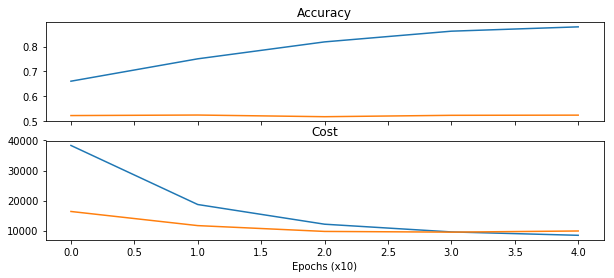

In [443]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(10,4))

ax1.plot(accuracy_summary) # blue
ax1.plot(valid_accuracy_summary) # green
ax1.set_title('Accuracy')

ax2.plot(cost_summary)
ax2.plot(valid_cost_summary)
ax2.set_title('Cost')

plt.xlabel('Epochs (x10)')
plt.show()

The prediction accuracy of all the machine learning model is pretty low even after tuning the parameters. But after applying RNN, the accuracy increased greatly. From figure 6.6 we can see that the accuracy is improved step by step and the cost becomes lower and lower. The experimental results show that individually, deep learning model outperformed a simple machine learning model. 

# License
This project is licensed under the MIT License - see the file [LICENSE.md](https://github.com/JiaminWangM/Research-Notebook/blob/master/LICENSE) for details

# Citation
Chris Mehrvarz, models_chris_rebalance_class [Source code](https://github.com/mehrvch/Porto_Seguro/blob/master/ipynb/models_chris_rebalance_class.ipynb)

Currie, Predicting Fraud with TensorFlow
 [Source code](https://www.kaggle.com/currie32/predicting-fraud-with-tensorflow)